In [9]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain.schema import SystemMessage, HumanMessage
from langchain.chat_models import ChatOpenAI
import json, os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
openai_api_key= os.getenv("OPENAI_API_KEY")

from prompts import prompt
from icl import SampleGenerator
from validate_syntax import is_valid_code

task_description= "Move robot from home to point A."

dataset_path= "data/dataset.jsonl"
generator = SampleGenerator(dataset_path)
icl_samples= generator.demonstrations()


class WandelScriptGenerator:
    def __init__(self, model="gpt-4o-mini"):
        self.model = model

    def generate_code(self, state):
        system_msg, user_msg = state['system_msg'], state['user_msg']
        messages = [
            SystemMessage(content=system_msg, **{"icl_samples": icl_samples}),
            HumanMessage(content=user_msg)
        ]
        llm = ChatOpenAI(openai_api_key=openai_api_key,
                         temperature=0.7,
                         model=self.model,
                         verbose=True)
        result = llm.invoke(messages)
        generated_output = json.loads(result.content)
        return {
            "system_msg": system_msg,
            "user_msg": user_msg,
            "generated_code": generated_output["code"]
        }

    def validate_code(self, state):
        code = state["generated_code"]
        is_valid, error_msg = is_valid_code(code)
        state["is_valid"] = is_valid
        state["error_msg"] = error_msg
        return state

    def prepare_retry_prompt(self, state):
        consolidated_prompt = (
            f"The previous code generation failed due to the following syntax errors:\n"
            f"{state['error_msg']}\n\n"
            f"Task Description: {state['user_msg']}\n\n"
            f"Generated Code:\n{state['generated_code']}\n\n"
            f"Please regenerate a syntactically correct script that resolves the above errors."
        )
        return {
            "system_msg": state["system_msg"],
            "user_msg": consolidated_prompt
        }

# Instantiate Generator
ws_gen = WandelScriptGenerator()

# Build LangGraph State Machine
builder = StateGraph(state_schema=dict)

# Node 1: Generate code
builder.add_node("Generate WS", ws_gen.generate_code)

# Node 2: Validate code
builder.add_node("Validate WS", ws_gen.validate_code)

# Node 3: Prepare retry prompt
builder.add_node("retry_prompt", ws_gen.prepare_retry_prompt)

# Node 4: Return output node (clean end)
builder.add_node("return_output", lambda state: state)

# Edges
builder.set_entry_point("Generate WS")
builder.add_edge("Generate WS", "Validate WS")
builder.add_conditional_edges(
    "Validate WS",
    path=lambda state: "return_output" if state.get("is_valid") else "retry_prompt"
)
builder.add_edge("retry_prompt", "Generate WS")
builder.add_edge("return_output", END)

# Compile Graph
graph = builder.compile()

# Run
initial_state = {
    "system_msg": prompt,
    "user_msg": task_description
}
final_state = graph.invoke(initial_state)

# Output result
print(f"Task description: {task_description}")
print("\nGenerated WandelScript:\n")
if "generated_code" in final_state:
    print(final_state["generated_code"])
else:
    print("Code not returned. Final state:\n", final_state)

/var/folders/4h/2rr5nwrj3t5_r7g_lmcb4lh00000gn/T/ipykernel_47059/1586885912.py:31: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(openai_api_key=openai_api_key,


Task description: Move robot from home to point A.

Generated WandelScript:

home = (0, 0, 0, 0, 0, 0)
point_A = (100, 100, 100, 0, 0, 0)
tcp("Flange")
robot = get_controller("controller_name")[0]
do with robot:
    move via p2p() to point_A
    wait(500)
    print("Moved to point A.")


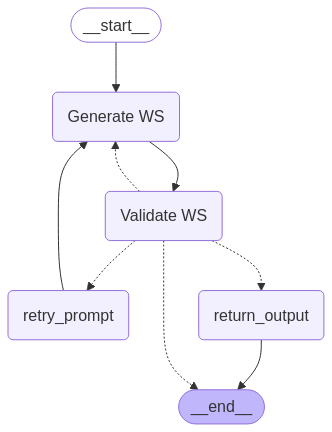

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)